In [76]:
# TODO: Do EDA of NUM_SAMPLES of the data
# WIP: May split this up so you don't have to rerun everything each time
# WIP: Make plots transparent so you can see overlap


# Data used is from sample tsv, results are random since it's not split into groups of 5 
# so preporcessed data should look better
import pickle
import pprint
import pandas as pd
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(pickle.load(open('./data/train/meta.pkl', 'rb')))
train_data = pickle.load(open('./data/train/meta.pkl', 'rb'))
test_data = pickle.load(open('./data/test/meta.pkl', 'rb'))
# data = data[0:100]
# data.to_csv('./data/train/meta.csv')
# print(data.keys())
# print()
# print(data['01088_A05_P010740_S00_N33_R1.mzML'].keys())
# print()
# print(type(data['01088_A05_P010740_S00_N33_R1.mzML'][47994]))
# print(len(data['01088_A05_P010740_S00_N33_R1.mzML'][47994]))


# for mzml_file in data:
#     for scan_num in data[mzml_file]:
#         print("Scan " + str(scan_num) + ": " + str(len(data[mzml_file][scan_num])))

print(train_data['01088_A05_P010740_S00_N33_R1.mzML'][43515]['Label'])

# print(t)

975      True
986     False
990     False
991     False
999     False
1001    False
Name: Label, dtype: bool


In [77]:
# Columns we will be measuring
score_columns = ['MSGFScore', 'DeNovoScore', 'SpecEValue', 'EValue']

# Build 'true_<score_column>' columns so that false rows can compare their
# scores to their associated true row

for dataset in [train_data, test_data]:
    for score_column in score_columns:
        for outer_key, inner_dict in dataset.items():
            # Loop through inner dictionary
            for inner_key, df in inner_dict.items():
                # Get true value if exists
                true_row = df[df['Label'] == 1].iloc[0]
                if true_row is not None:
                    df['true_' + score_column] = true_row[score_column]
                else:
                    df['true_' + score_column] = None

# print(train_data['01088_A05_P010740_S00_N33_R1.mzML'][43515])

In [78]:
full_dfs = []

for dataset in [train_data, test_data]:
    df_list = []
    for outer_key, inner_dict in dataset.items():
        # Loop through inner dictionary
        for inner_key, df in inner_dict.items():
            # Create a copy of the dataframe to avoid modifying the original
            df_copy = df.copy()
            # Add outer and inner keys as columns
            df_copy['outer_key'] = outer_key
            df_copy['inner_key'] = inner_key
            # Append the dataframe to the list
            df_list.append(df_copy)
    
    # Concatenate all dataframes in the list
    full_df = pd.concat(df_list, ignore_index=True)
    full_dfs.append(full_df)

train_full_df = full_dfs[0]
test_full_df = full_dfs[1]

In [79]:
for dataset in [train_full_df, test_full_df]:
    dataset.columns = dataset.columns.str.strip() 
    dataset['Peptide'] = dataset['Peptide'].str.strip()
    dataset['peptide_length'] = dataset['Peptide'].str.len()

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_score(dataset, score_column, similarity_threshold=0.1):
    true_rows = dataset[dataset['Label'] == True]
    false_rows = dataset[dataset['Label'] == False]

    true_scores = true_rows[score_column]
    false_scores = false_rows[score_column]

    # Calculate summary statistics
    true_mean_all = round(true_scores.mean(), 3)
    true_std_all = round(true_scores.std(), 3)
    false_mean_all = round(false_scores.mean(), 3)
    false_std_all = round(false_scores.std(), 3)

    print(f"True rows {score_column} mean: {true_mean_all}, std: {true_std_all}")
    print(f"False rows {score_column} mean: {false_mean_all}, std: {false_std_all}")

    # # Compare false row scores with their associated true row
    # # Select rows within similarity threshold percentage
    true_score_col = "true_" + score_column
    # non_null_false_rows = 
    false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])
    close_rows = false_rows[false_rows['score_diff'] <= similarity_threshold]
    print("\nFalse rows with similar " + score_column + " scores to their associated true rows:")
    print("Threshold is " + str(similarity_threshold*100) + "% difference")
    print(len(close_rows), "rows or", round(len(close_rows)/len(false_rows)*100, 2), "% of false rows")

    # Score distribution
    plt.figure()
    plt.hist(true_scores, bins=30, alpha=0.5, label='True rows', color='green')
    plt.hist(false_scores, bins=30, alpha=0.5, label='False rows', color='red')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(score_column + ' Score Distribution')
    plt.show()

    # Compare length of peptide string to scores
    plt.figure()
    plt.scatter(true_rows[score_column], true_rows['peptide_length'], alpha=0.2, label='True rows', color='green', marker='o')
    plt.scatter(false_rows[score_column], false_rows['peptide_length'], alpha=0.2, label='False rows', color='red', marker='x')
    plt.xlabel("Score")
    plt.ylabel("Peptide Length")
    plt.title("Peptide Length vs " + score_column + " Scores")
    plt.show()
    
    # Find average scores for peptides containing modification, e.g. "C+", "M+", "N+"
    modifications = ['C+', 'M+', 'N+', 'Q+']
    for modification in modifications:
        # Get all true and false rows that contain the modification in Peptide name
        true_modification = true_rows[true_rows['Peptide'].str.contains(modification)]
        false_modification = false_rows[false_rows['Peptide'].str.contains(modification)]

        true_mean = round(true_modification[score_column].mean(), 3)
        true_std = round(true_modification[score_column].std(), 3)
        false_mean = round(false_modification[score_column].mean(), 3)
        false_std = round(false_modification[score_column].std(), 3)

        # get diffs in formatted strings
        true_avg_diff = round(true_mean - true_mean_all, 3)
        true_avg_diff = '{0:+}'.format(true_avg_diff)
        false_avg_diff = round(false_mean - false_mean_all, 3)
        false_avg_diff = '{0:+}'.format(false_avg_diff)

        # Print summary statistics
        print("Data for rows containing modification " + modification)
        print(f"    {modification} True rows {score_column} mean: {true_mean} ({true_avg_diff} vs all true rows), std: {true_std}")
        print(f"    {modification} False rows {score_column} mean: {false_mean} ({false_avg_diff} vs all false rows), std: {false_std}")




--TRAINING DATA--
----------------------------------------
Analyzing score column: MSGFScore
True rows MSGFScore mean: 82.982, std: 63.02
False rows MSGFScore mean: 8.919, std: 17.011

False rows with similar MSGFScore scores to their associated true rows:
Threshold is 10.0% difference
6 rows or 0.01 % of false rows


C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


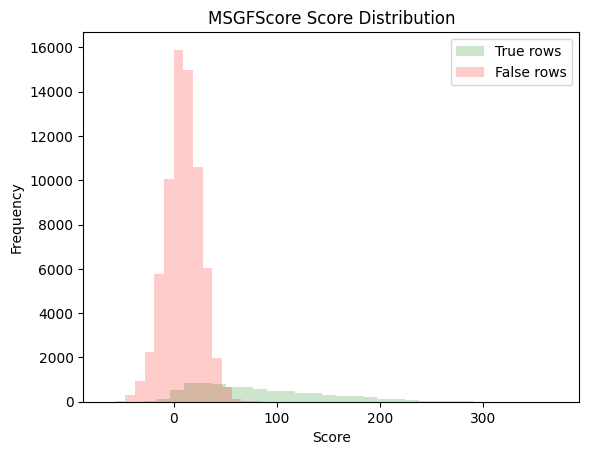

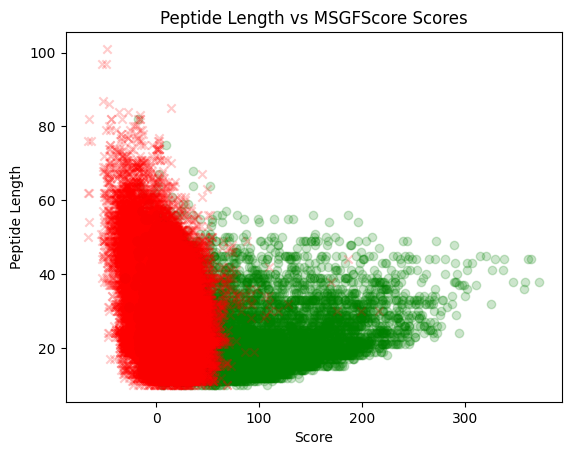

Data for rows containing modification C+
    C+ True rows MSGFScore mean: 65.577 (-17.405 vs all true rows), std: 68.972
    C+ False rows MSGFScore mean: 4.903 (-4.016 vs all false rows), std: 17.094
Data for rows containing modification M+
    M+ True rows MSGFScore mean: 80.928 (-2.054 vs all true rows), std: 65.255
    M+ False rows MSGFScore mean: 7.594 (-1.325 vs all false rows), std: 17.597
Data for rows containing modification N+
    N+ True rows MSGFScore mean: 89.949 (+6.967 vs all true rows), std: 67.735
    N+ False rows MSGFScore mean: 8.398 (-0.521 vs all false rows), std: 17.717
Data for rows containing modification Q+
    Q+ True rows MSGFScore mean: 81.806 (-1.176 vs all true rows), std: 65.496
    Q+ False rows MSGFScore mean: 8.645 (-0.274 vs all false rows), std: 17.61


----------------------------------------
Analyzing score column: DeNovoScore
True rows DeNovoScore mean: 120.851, std: 60.308
False rows DeNovoScore mean: 119.81, std: 59.942

False rows with simila

C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


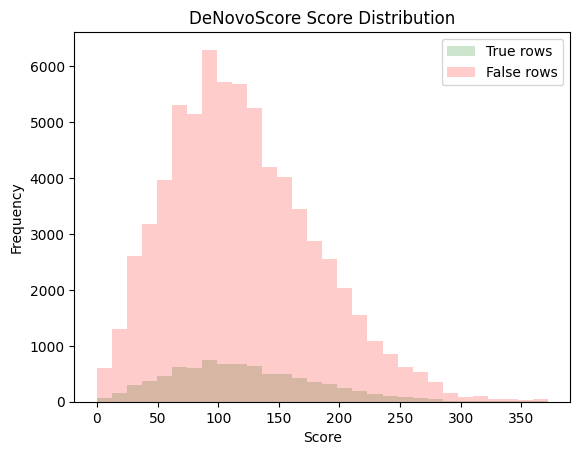

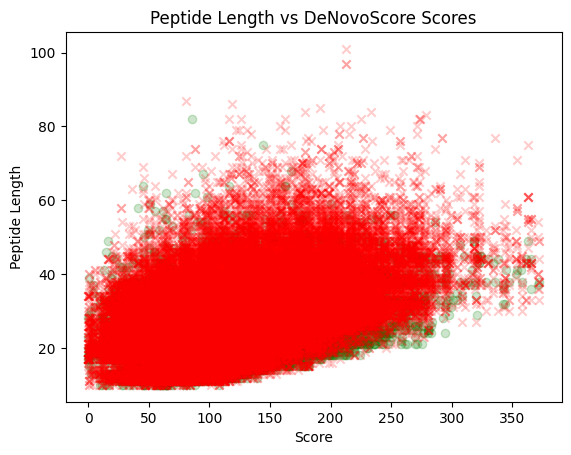

Data for rows containing modification C+
    C+ True rows DeNovoScore mean: 116.562 (-4.289 vs all true rows), std: 70.066
    C+ False rows DeNovoScore mean: 126.076 (+6.266 vs all false rows), std: 62.285
Data for rows containing modification M+
    M+ True rows DeNovoScore mean: 126.709 (+5.858 vs all true rows), std: 63.903
    M+ False rows DeNovoScore mean: 129.302 (+9.492 vs all false rows), std: 62.416
Data for rows containing modification N+
    N+ True rows DeNovoScore mean: 134.081 (+13.23 vs all true rows), std: 62.335
    N+ False rows DeNovoScore mean: 130.585 (+10.775 vs all false rows), std: 61.156
Data for rows containing modification Q+
    Q+ True rows DeNovoScore mean: 124.816 (+3.965 vs all true rows), std: 61.437
    Q+ False rows DeNovoScore mean: 127.144 (+7.334 vs all false rows), std: 61.262


----------------------------------------
Analyzing score column: SpecEValue
True rows SpecEValue mean: 0.0, std: 0.0
False rows SpecEValue mean: 0.0, std: 0.0

False row

C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


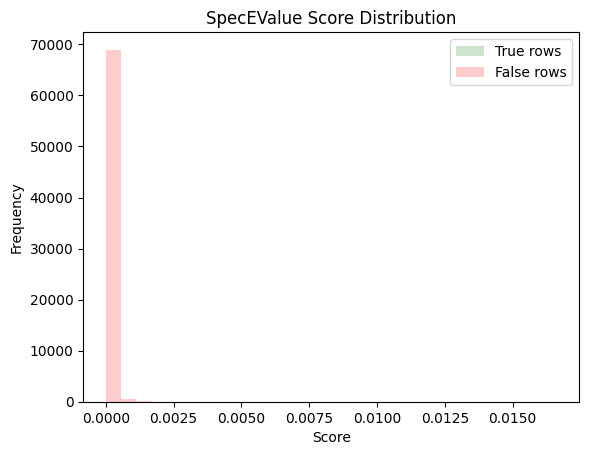

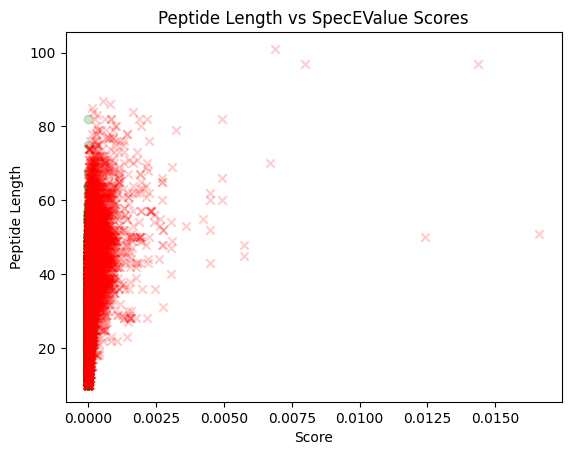

Data for rows containing modification C+
    C+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    C+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.0
Data for rows containing modification M+
    M+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    M+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.0
Data for rows containing modification N+
    N+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    N+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.0
Data for rows containing modification Q+
    Q+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    Q+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.0


----------------------------------------
Analyzing score column: EValue
True rows EValue mean: 0.778, std: 1.372
False rows EValue mean: 1304.365, std: 5292.06

False rows with similar EValue scores to their associated true rows:
Threshold is 10.0% d

C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


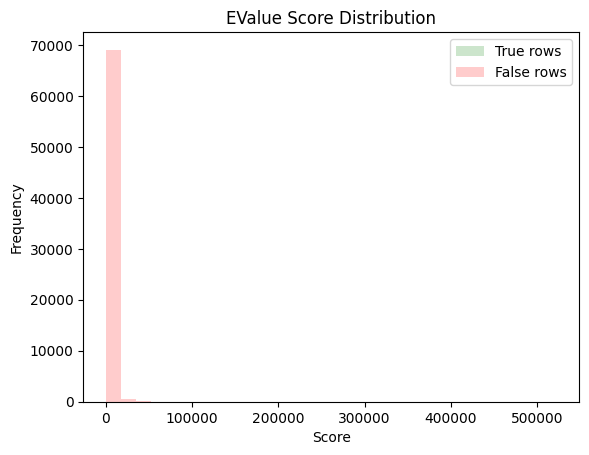

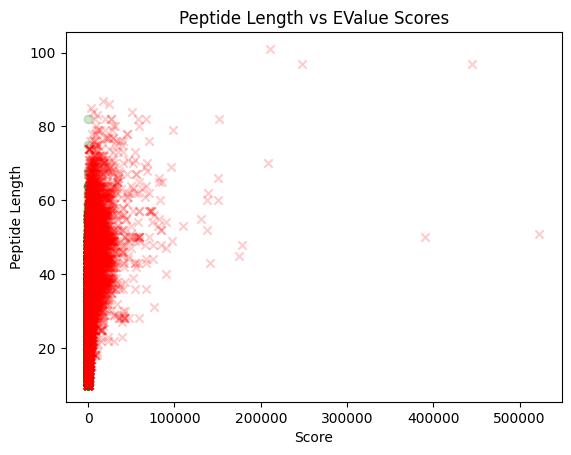

Data for rows containing modification C+
    C+ True rows EValue mean: 1.262 (+0.484 vs all true rows), std: 1.559
    C+ False rows EValue mean: 1988.772 (+684.407 vs all false rows), std: 7155.989
Data for rows containing modification M+
    M+ True rows EValue mean: 0.846 (+0.068 vs all true rows), std: 1.442
    M+ False rows EValue mean: 1817.128 (+512.763 vs all false rows), std: 6622.525
Data for rows containing modification N+
    N+ True rows EValue mean: 0.75 (-0.028 vs all true rows), std: 1.376
    N+ False rows EValue mean: 1698.466 (+394.101 vs all false rows), std: 6206.622
Data for rows containing modification Q+
    Q+ True rows EValue mean: 0.943 (+0.165 vs all true rows), std: 1.48
    Q+ False rows EValue mean: 1561.748 (+257.383 vs all false rows), std: 6211.707




In [81]:
print("--TRAINING DATA--")
for score_column in score_columns:
        print("----------------------------------------")
        print("Analyzing score column:", score_column)
        analyze_score(train_full_df, score_column, similarity_threshold=0.1)
        print("\n")

--TEST DATA--
----------------------------------------
Analyzing score column: MSGFScore
True rows MSGFScore mean: 144.964, std: 51.268
False rows MSGFScore mean: 19.926, std: 17.257

False rows with similar MSGFScore scores to their associated true rows:
Threshold is 10.0% difference
18 rows or 0.03 % of false rows


C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


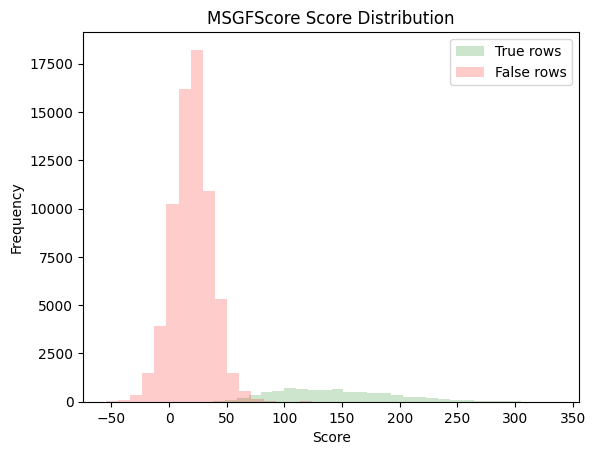

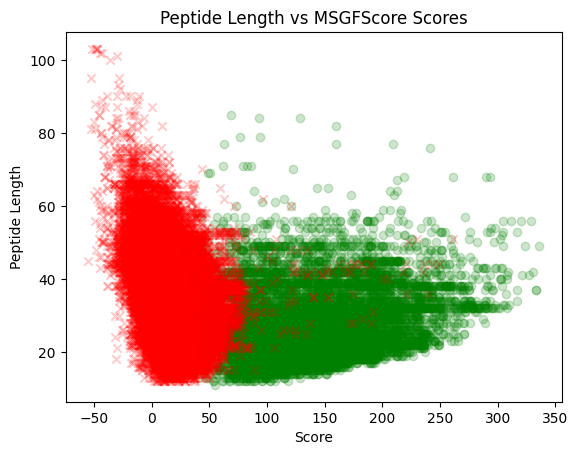

Data for rows containing modification C+
    C+ True rows MSGFScore mean: 155.597 (+10.633 vs all true rows), std: 56.179
    C+ False rows MSGFScore mean: 16.652 (-3.274 vs all false rows), std: 17.245
Data for rows containing modification M+
    M+ True rows MSGFScore mean: 149.682 (+4.718 vs all true rows), std: 52.254
    M+ False rows MSGFScore mean: 18.737 (-1.189 vs all false rows), std: 17.152
Data for rows containing modification N+
    N+ True rows MSGFScore mean: 148.558 (+3.594 vs all true rows), std: 51.908
    N+ False rows MSGFScore mean: 19.318 (-0.608 vs all false rows), std: 17.818
Data for rows containing modification Q+
    Q+ True rows MSGFScore mean: 151.935 (+6.971 vs all true rows), std: 55.005
    Q+ False rows MSGFScore mean: 19.821 (-0.105 vs all false rows), std: 18.139


----------------------------------------
Analyzing score column: DeNovoScore
True rows DeNovoScore mean: 172.655, std: 50.86
False rows DeNovoScore mean: 172.167, std: 50.725

False rows wi

C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


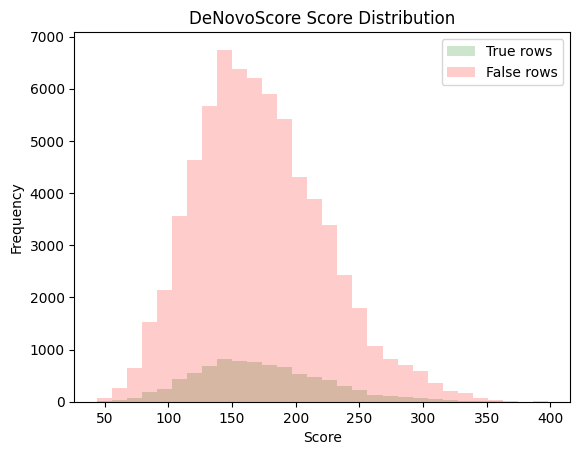

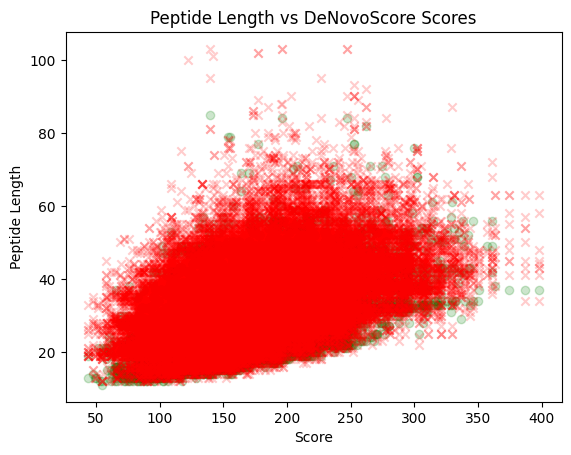

Data for rows containing modification C+
    C+ True rows DeNovoScore mean: 188.375 (+15.72 vs all true rows), std: 52.308
    C+ False rows DeNovoScore mean: 176.11 (+3.943 vs all false rows), std: 51.047
Data for rows containing modification M+
    M+ True rows DeNovoScore mean: 179.417 (+6.762 vs all true rows), std: 49.985
    M+ False rows DeNovoScore mean: 177.433 (+5.266 vs all false rows), std: 51.001
Data for rows containing modification N+
    N+ True rows DeNovoScore mean: 181.587 (+8.932 vs all true rows), std: 50.594
    N+ False rows DeNovoScore mean: 177.333 (+5.166 vs all false rows), std: 51.256
Data for rows containing modification Q+
    Q+ True rows DeNovoScore mean: 183.495 (+10.84 vs all true rows), std: 52.789
    Q+ False rows DeNovoScore mean: 176.952 (+4.785 vs all false rows), std: 51.419


----------------------------------------
Analyzing score column: SpecEValue
True rows SpecEValue mean: 0.0, std: 0.0
False rows SpecEValue mean: 0.0, std: 0.0

False rows 

C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


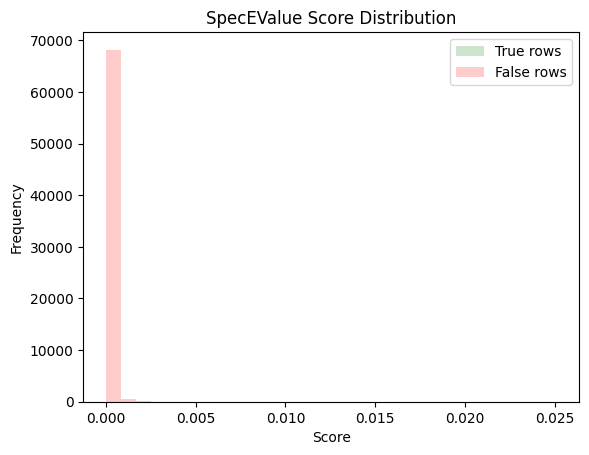

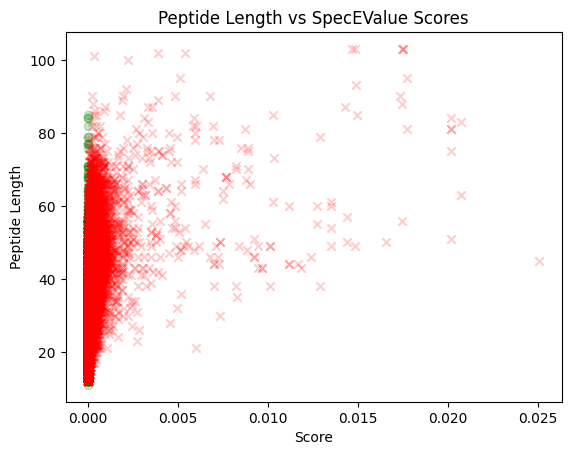

Data for rows containing modification C+
    C+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    C+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.001
Data for rows containing modification M+
    M+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    M+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.001
Data for rows containing modification N+
    N+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    N+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.001
Data for rows containing modification Q+
    Q+ True rows SpecEValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    Q+ False rows SpecEValue mean: 0.0 (+0.0 vs all false rows), std: 0.001


----------------------------------------
Analyzing score column: EValue
True rows EValue mean: 0.0, std: 0.0
False rows EValue mean: 2947.048, std: 15010.665

False rows with similar EValue scores to their associated true rows:
Threshold is 1

C:\Users\mcgin\AppData\Local\Temp\ipykernel_17692\3094266467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


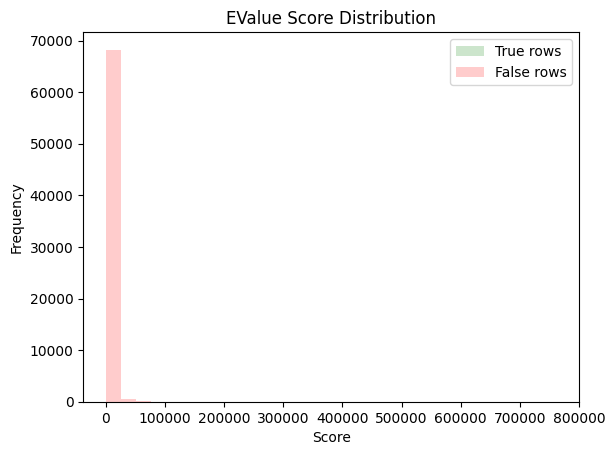

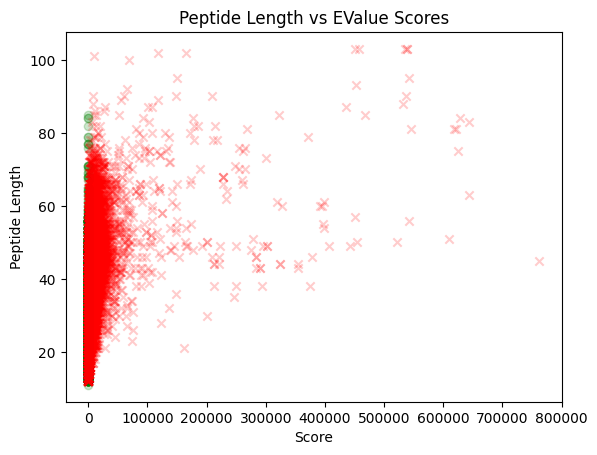

Data for rows containing modification C+
    C+ True rows EValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    C+ False rows EValue mean: 4320.715 (+1373.667 vs all false rows), std: 20368.325
Data for rows containing modification M+
    M+ True rows EValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    M+ False rows EValue mean: 3499.545 (+552.497 vs all false rows), std: 16556.013
Data for rows containing modification N+
    N+ True rows EValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    N+ False rows EValue mean: 3308.436 (+361.388 vs all false rows), std: 16147.71
Data for rows containing modification Q+
    Q+ True rows EValue mean: 0.0 (+0.0 vs all true rows), std: 0.0
    Q+ False rows EValue mean: 3252.678 (+305.63 vs all false rows), std: 16831.6




In [82]:
print("--TEST DATA--")
for score_column in score_columns:
        print("----------------------------------------")
        print("Analyzing score column:", score_column)
        analyze_score(test_full_df, score_column, similarity_threshold=0.1)
        print("\n")

In [83]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# NUM_PEPTIDES_PER_SPECTRUM = 5

# # WIP: perform the true/false correlation analysis for these score columns: MSGFScore, IsotopeError, PrecursorError, DeNovoScore, SpecEValue, EValue
# # WIP: adjust this to work with the new data format [mzml][scan_num] = df for that scan
# def analyze_score(file_path, score_column, similarity_threshold=0.1):
#     # Load CSV data
#     # TSV
#     df = pd.read_csv(file_path, sep='\t')
#     # Remove whitespace from column names
#     df.columns = df.columns.str.strip() 
#     # Strip peptide names
#     df['Peptide'] = df['Peptide'].str.strip()
#     # add peptide length column for later
#     df['peptide_length'] = df['Peptide'].str.len()

#     # print(df.keys())
    
#     # Separate true and false rows
#     true_rows = df.iloc[::NUM_PEPTIDES_PER_SPECTRUM]
#     false_rows = df.drop(true_rows.index)

#     true_scores = true_rows[score_column]
#     false_scores = false_rows[score_column]

#     # Calculate summary statistics
#     true_mean_all = round(true_scores.mean(), 3)
#     true_std_all = round(true_scores.std(), 3)
#     false_mean_all = round(false_scores.mean(), 3)
#     false_std_all = round(false_scores.std(), 3)

#     print(f"True rows {score_column} mean: {true_mean_all}, std: {true_std_all}")
#     print(f"False rows {score_column} mean: {false_mean_all}, std: {false_std_all}")

#     # Compare false row scores with their associated true row
#     false_rows['true_score'] = np.repeat(true_scores.values, NUM_PEPTIDES_PER_SPECTRUM-1)

#     # Select rows within similarity threshold percentage
#     false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows['true_score']) / false_rows['true_score'])
#     close_rows = false_rows[false_rows['score_diff'] <= similarity_threshold]

#     print("\nFalse rows with similar " + score_column + " scores to their associated true rows:")
#     print("Threshold is " + str(similarity_threshold*100) + "% difference")
#     print(len(close_rows), "rows or", round(len(close_rows)/len(false_rows)*100, 2), "% of false rows")

#     # Score distribution
#     plt.figure()
#     plt.hist(true_scores, bins=30, alpha=0.5, label='True rows', color='green')
#     plt.hist(false_scores, bins=30, alpha=0.5, label='False rows', color='red')
#     plt.xlabel('Score')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.title(score_column + ' Score Distribution')
#     plt.show()

#     # Compare length of peptide string to scores
#     plt.figure()
#     plt.scatter(true_rows[score_column], true_rows['peptide_length'], label='True rows', color='green', marker='o')
#     plt.scatter(false_rows[score_column], false_rows['peptide_length'], label='False rows', color='red', marker='x')
#     plt.xlabel("Score")
#     plt.ylabel("Peptide Length")
#     plt.title("Peptide Length vs " + score_column + " Scores")
#     plt.show()
    
#     # Find average scores for peptides containing modification, e.g. "C+", "M+", "N+"
#     modifications = ['C+', 'M+', 'N+', 'Q+']
#     for modification in modifications:
#         # Get all true and false rows that contain the modification in Peptide name
#         true_modification = true_rows[true_rows['Peptide'].str.contains(modification)]
#         false_modification = false_rows[false_rows['Peptide'].str.contains(modification)]

#         true_mean = round(true_modification[score_column].mean(), 3)
#         true_std = round(true_modification[score_column].std(), 3)
#         false_mean = round(false_modification[score_column].mean(), 3)
#         false_std = round(false_modification[score_column].std(), 3)

#         # get diffs in formatted strings
#         true_avg_diff = round(true_mean - true_mean_all, 3)
#         true_avg_diff = '{0:+}'.format(true_avg_diff)
#         false_avg_diff = round(false_mean - false_mean_all, 3)
#         false_avg_diff = '{0:+}'.format(false_avg_diff)

#         # Print summary statistics
#         print("Data for rows containing modification " + modification)
#         print(f"    {modification} True rows {score_column} mean: {true_mean} ({true_avg_diff} vs all true rows), std: {true_std}")
#         print(f"    {modification} False rows {score_column} mean: {false_mean} ({false_avg_diff} vs all false rows), std: {false_std}")

# # Example usage
# score_columns = ['MSGFScore', 'IsotopeError', 'PrecursorError(ppm)', 'DeNovoScore', 'SpecEValue', 'EValue']
# for score_column in score_columns:
#     print("----------------------------------------")
#     print("Analyzing score column:", score_column)
#     analyze_score('abc.tsv', score_column, similarity_threshold=0.1)
#     print("\n")

